### Preprocessing steps

In [1]:
# import libraries 
import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer  # (kept for template; you said no nulls)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, classification_report
# High-cardinality encoder (fast, memory-safe)
from category_encoders.hashing import HashingEncoder
#from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder

In [2]:
#!pip install category_encoders

In [3]:
data = pd.read_csv('eda_dataset.csv')

In [4]:
# drop amt_clean because i have removed outlier from it and in fraud cases amount is important so instead of removing im capping upper limit here with fic amount 
data = data.drop(columns = ['amt_clean'])

# will create new clean_amount column after splitting data to prevent data leakage (means we nor use test data for capping so that we can get realistic model performance)

In [5]:
#Number of transactions per card
data['card_txn_count'] = data.groupby('cc_num')['cc_num'].transform('count')

In [6]:
data.columns

Index(['cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'tr_year', 'tr_month', 'tr_day', 'tr_hour', 'tr_minute', 'age',
       'age_group', 'tr_day_name', 'distance_cust_merchant_km',
       'card_txn_count'],
      dtype='object')

In [7]:
data_c = data.select_dtypes(include=['object'])

In [8]:
for c in data_c:
    print( c ,':',data_c[c].nunique())

merchant : 693
category : 14
first : 355
last : 486
gender : 2
street : 999
city : 906
state : 51
job : 497
dob : 984
trans_num : 1852394
unix_time : 1819583
age_group : 3
tr_day_name : 7


In [9]:
data_n = data.select_dtypes(include=['number'])

In [10]:
for c in data_n:
    print( c ,':',data_n[c].nunique())

cc_num : 999
amt : 60616
zip : 985
lat : 983
long : 983
city_pop : 891
merch_lat : 1754157
merch_long : 1809753
is_fraud : 2
tr_year : 2
tr_month : 12
tr_day : 7
tr_hour : 24
tr_minute : 60
age : 83
distance_cust_merchant_km : 14547
card_txn_count : 140


In [11]:
data.head()

,cc_num,merchant,category,amt,first,last,gender,street,city,state,...,tr_year,tr_month,tr_day,tr_hour,tr_minute,age,age_group,tr_day_name,distance_cust_merchant_km,card_txn_count
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,...,2019,1,1,0,0,31,adult,Tuesday,78.60,2927
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,...,2019,1,1,0,0,41,adult,Tuesday,30.21,4362
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,...,2019,1,1,0,0,57,senior,Tuesday,108.21,735
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,...,2019,1,1,0,1,52,senior,Tuesday,95.67,743
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,...,2019,1,1,0,3,33,adult,Tuesday,77.56,2922


(array([   904., 163026.,      0., 299065., 383752.,  70412., 444101.,
             0., 259153., 231981.]),
 array([   6. ,  444.6,  883.2, 1321.8, 1760.4, 2199. , 2637.6, 3076.2,
        3514.8, 3953.4, 4392. ]),
 <BarContainer object of 10 artists>)

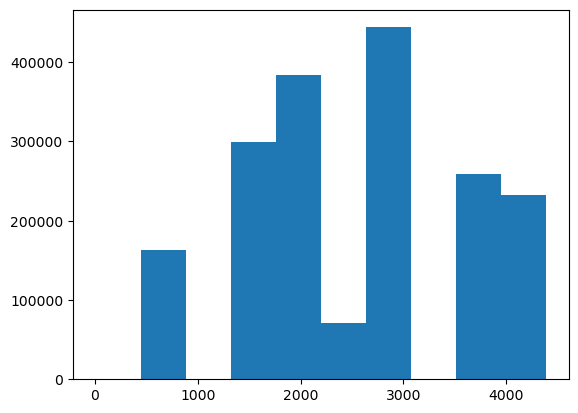

In [12]:
plt.hist(data['card_txn_count'])

In [13]:
# data.groupby('tr_year')['is_fraud'].mean()

#The fraud rates in both years are almost the same
#Difference = 0.000867 → less than 0.1% difference

In [14]:

data = data.drop(columns = ['cc_num','first', 'last','street','lat', 'long','dob','trans_num','unix_time','merch_lat', 'merch_long',
                           'age_group','tr_day_name'],axis=1)

In [15]:
# step 1 to balance and reduce data 
fraud = data[data['is_fraud'] == 1]
non_fraud = data[data['is_fraud'] == 0]

In [16]:
# Step 2: Sample non-fraud rows to reduce dataset size and control class imbalance
# Here we're keeping a 10:1 ratio of non-fraud to fraud (can change to 5, 20, etc.)
# random_state=42  # for reproducibility
non_fraud_sampled = non_fraud.sample(n = min(len(non_fraud), len(fraud)*10), random_state = 42)

In [17]:
# Step 3: Combine fraud and sampled non-fraud into one dataset
reduced_data = pd.concat([fraud, non_fraud_sampled])

In [18]:
# Step 4: Shuffle the combined dataset so fraud and non-fraud are mixed
reduced_data = reduced_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [19]:
# Optional: Check class balance
print(reduced_data['is_fraud'].value_counts(normalize=True))  # See class distribution
print(reduced_data.shape)  # Check total rows

is_fraud
0    0.909091
1    0.090909
Name: proportion, dtype: float64
(106161, 18)


In [20]:
reduced_data.head()

,merchant,category,amt,gender,city,state,zip,city_pop,job,is_fraud,tr_year,tr_month,tr_day,tr_hour,tr_minute,age,distance_cust_merchant_km,card_txn_count
0,"fraud_Becker, Harris and Harvey",personal_care,43.45,M,Tallmansville,WV,26237,571,Accounting technician,0,2020,7,3,14,47,53,22.77,2920
1,fraud_Terry-Huel,shopping_net,8.27,F,Sun City,CA,92585,54287,"Designer, exhibition/display",0,2020,6,1,12,15,48,54.38,4378
2,"fraud_Hettinger, McCullough and Fay",home,2.44,F,Houston,TX,77007,2906700,"Copywriter, advertising",0,2019,1,6,13,39,35,82.79,3644
3,"fraud_Nicolas, Hills and McGlynn",entertainment,35.46,M,Mallie,KY,41836,798,Facilities manager,0,2019,12,0,23,16,93,70.89,2924
4,"fraud_Lang, Towne and Schuppe",kids_pets,19.77,F,Centerview,MO,64019,2368,Electronics engineer,1,2019,1,2,22,46,30,98.49,4380


In [21]:
reduced_data.shape

(106161, 18)

In [22]:
reduced_data.columns

Index(['merchant', 'category', 'amt', 'gender', 'city', 'state', 'zip',
       'city_pop', 'job', 'is_fraud', 'tr_year', 'tr_month', 'tr_day',
       'tr_hour', 'tr_minute', 'age', 'distance_cust_merchant_km',
       'card_txn_count'],
      dtype='object')

In [23]:
def add_cyclic_features(df):

    df["tr_month_sin"]  = np.sin(2*np.pi*df["tr_month"]/12)
    df["tr_month_cos"]  = np.cos(2*np.pi*df["tr_month"]/12)

    df["tr_day_sin"]    = np.sin(2*np.pi*df["tr_day"]/31)
    df["tr_day_cos"]    = np.cos(2*np.pi*df["tr_day"]/31)

    df["tr_hour_sin"]   = np.sin(2*np.pi*df["tr_hour"]/24)
    df["tr_hour_cos"]   = np.cos(2*np.pi*df["tr_hour"]/24)

    df["tr_minute_sin"] = np.sin(2*np.pi*df["tr_minute"]/60)
    df["tr_minute_cos"] = np.cos(2*np.pi*df["tr_minute"]/60)
    
    df = df.drop(columns=["tr_month", "tr_day", "tr_hour", "tr_minute"])

    return df

reduced_data = add_cyclic_features(reduced_data)

In [24]:
reduced_data.head()

,merchant,category,amt,gender,city,state,zip,city_pop,job,is_fraud,...,distance_cust_merchant_km,card_txn_count,tr_month_sin,tr_month_cos,tr_day_sin,tr_day_cos,tr_hour_sin,tr_hour_cos,tr_minute_sin,tr_minute_cos
0,"fraud_Becker, Harris and Harvey",personal_care,43.45,M,Tallmansville,WV,26237,571,Accounting technician,0,...,22.77,2920,-5.000000e-01,-0.866025,0.571268,0.820763,-5.000000e-01,-0.866025,-0.978148,2.079117e-01
1,fraud_Terry-Huel,shopping_net,8.27,F,Sun City,CA,92585,54287,"Designer, exhibition/display",0,...,54.38,4378,1.224647e-16,-1.000000,0.201299,0.979530,1.224647e-16,-1.000000,1.000000,2.832769e-16
2,"fraud_Hettinger, McCullough and Fay",home,2.44,F,Houston,TX,77007,2906700,"Copywriter, advertising",0,...,82.79,3644,5.000000e-01,0.866025,0.937752,0.347305,-2.588190e-01,-0.965926,-0.809017,-5.877853e-01
3,"fraud_Nicolas, Hills and McGlynn",entertainment,35.46,M,Mallie,KY,41836,798,Facilities manager,0,...,70.89,2924,-2.449294e-16,1.000000,0.000000,1.000000,-2.588190e-01,0.965926,0.994522,-1.045285e-01
4,"fraud_Lang, Towne and Schuppe",kids_pets,19.77,F,Centerview,MO,64019,2368,Electronics engineer,1,...,98.49,4380,5.000000e-01,0.866025,0.394356,0.918958,-5.000000e-01,0.866025,-0.994522,1.045285e-01


In [25]:
reduced_data.columns

Index(['merchant', 'category', 'amt', 'gender', 'city', 'state', 'zip',
       'city_pop', 'job', 'is_fraud', 'tr_year', 'age',
       'distance_cust_merchant_km', 'card_txn_count', 'tr_month_sin',
       'tr_month_cos', 'tr_day_sin', 'tr_day_cos', 'tr_hour_sin',
       'tr_hour_cos', 'tr_minute_sin', 'tr_minute_cos'],
      dtype='object')

In [26]:
#reduced_data['distance_cust_merchant_km'].max()

In [27]:
#reduced_data["amt"].max()

In [28]:
#reduced_data["city_pop"].max()

In [29]:
cat_low  = ["state", "category","gender", 'tr_year']      # OHE (<= ~100 uniques)
cat_high = ["merchant", "city", "job","zip"]                             # Hashing (693/906/497 uniques)
# 'gender' is low-card too; treat as binary OHE with drop='if_binary'

scale_cols = ["city_pop","age", "amt", "distance_cust_merchant_km",'card_txn_count']

In [30]:
X = reduced_data.drop(columns='is_fraud')
y=  reduced_data['is_fraud']

In [31]:
# Step 5: Split into Train (80%), Temp (20%) while keeping class ratio (stratify)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size= 0.2,stratify=y, random_state=42)

In [32]:
# Step 6: Split Temp into Validation (15%) and Test (15%),test_size=0.5,  # Half of 30% = 15%

# val_data, test_data = train_test_split(temp_data,test_size=0.5,stratify=temp_data['is_fraud'],random_state=42)

In [33]:
#SCALE numeric columns (fit on train only)
from sklearn.preprocessing import StandardScaler

scale_cols = ["amt", "distance_cust_merchant_km", "age", "city_pop"]

scaler = StandardScaler()

train_scaled_array = scaler.fit_transform(X_train[scale_cols])

# 2. Transform test numeric columns
test_scaled_array  = scaler.transform(X_test[scale_cols])

# 3. Convert back to DataFrames because scaling give munpy array not dataframe and we want dataframe 
train_scaled_df = pd.DataFrame(train_scaled_array, columns=scale_cols,index=X_train.index)

test_scaled_df = pd.DataFrame(test_scaled_array, columns=scale_cols,index=X_test.index)

In [34]:
#One-Hot Encode LOW cardinality
from sklearn.preprocessing import OneHotEncoder


cat_low = ["state", "category", "gender",'tr_year']

ohe = OneHotEncoder(handle_unknown="ignore",sparse_output=True,dtype=np.float32)

# Fit on train only
X_train_ohe = ohe.fit_transform(X_train[cat_low])
X_test_ohe  = ohe.transform(X_test[cat_low])

# Column names
ohe_cols = ohe.get_feature_names_out(cat_low)

# Convert back to DataFrames (IMPORTANT: keep original index!)
df_train_ohe = pd.DataFrame(X_train_ohe.toarray(),columns=ohe_cols,index=X_train.index)

df_test_ohe = pd.DataFrame(X_test_ohe.toarray(),columns=ohe_cols,index=X_test.index)

In [35]:
#Hashing Encode HIGH cardinality
from category_encoders.hashing import HashingEncoder

# converting zip into string because hashencoding treating it as numerical and not treating it
X_train['zip'] = X_train['zip'].astype(str)
X_test['zip']  = X_test['zip'].astype(str)

cat_high = ["merchant","zip", "city", "job",]

hash_enc = HashingEncoder(n_components=64)

df_train_hash = hash_enc.fit_transform(X_train[cat_high]).reset_index(drop=True)
df_test_hash  = hash_enc.transform(X_test[cat_high]).reset_index(drop=True)
df_train_hash.index = X_train.index
df_test_hash.index = X_test.index

In [36]:
print(df_train_hash.head())

       col_0  col_1  col_2  col_3  col_4  col_5  col_6  col_7  col_8  col_9  \
48902      0      1      1      0      0      0      0      0      0      0   
52011      0      1      0      0      0      0      0      0      0      0   
67759      0      0      0      1      0      0      0      0      0      0   
96261      0      0      0      0      0      0      0      0      0      0   
82735      0      0      0      0      0      0      0      0      0      0   

       ...  col_54  col_55  col_56  col_57  col_58  col_59  col_60  col_61  \
48902  ...       0       0       0       0       1       0       0       0   
52011  ...       0       0       0       0       0       0       0       0   
67759  ...       0       0       0       1       0       0       0       0   
96261  ...       0       0       0       1       0       0       0       0   
82735  ...       0       0       0       0       0       1       0       0   

       col_62  col_63  
48902       0       0  
52011   

In [37]:
# combine all scaling and encoding column in one and droped it from main df and then added updated one in remaing df
used_cols = scale_cols + cat_low + cat_high # all columns we already encoded

X_train_rest = X_train.drop(columns=used_cols)
X_test_rest = X_test.drop(columns= used_cols)
X_train_rest.columns

Index(['card_txn_count', 'tr_month_sin', 'tr_month_cos', 'tr_day_sin',
       'tr_day_cos', 'tr_hour_sin', 'tr_hour_cos', 'tr_minute_sin',
       'tr_minute_cos'],
      dtype='object')

In [38]:
# with scaling in numerical column
X_train_final = pd.concat([X_train_rest, train_scaled_df, df_train_ohe, df_train_hash],axis=1)

# Final test features
X_test_final = pd.concat([X_test_rest, test_scaled_df, df_test_ohe, df_test_hash],axis=1)

In [39]:
X_train_final.head()

,card_txn_count,tr_month_sin,tr_month_cos,tr_day_sin,tr_day_cos,tr_hour_sin,tr_hour_cos,tr_minute_sin,tr_minute_cos,amt,...,col_54,col_55,col_56,col_57,col_58,col_59,col_60,col_61,col_62,col_63
48902,2194,-8.660254e-01,-5.000000e-01,0.724793,0.688967,-8.660254e-01,0.500000,0.978148,-2.079117e-01,-0.213506,...,0,0,0,0,1,0,0,0,0,0
52011,4364,-5.000000e-01,-8.660254e-01,0.201299,0.979530,2.588190e-01,-0.965926,1.000000,2.832769e-16,-0.246821,...,0,0,0,0,0,0,0,0,0,0
67759,4369,-8.660254e-01,-5.000000e-01,0.201299,0.979530,5.000000e-01,0.866025,-0.406737,9.135455e-01,3.728787,...,0,0,0,1,0,0,0,0,0,0
96261,4364,-1.000000e+00,-1.836970e-16,0.848644,0.528964,-5.000000e-01,0.866025,0.978148,-2.079117e-01,0.112256,...,0,0,0,1,0,0,0,0,0,0
82735,1467,-2.449294e-16,1.000000e+00,0.394356,0.918958,1.224647e-16,-1.000000,-0.406737,9.135455e-01,-0.232613,...,0,0,0,0,0,1,0,0,0,0


In [40]:
# without scaling in numerical column
used_cols =  cat_low + cat_high
# print(used_cols)
X_train_rest = X_train.drop(columns=used_cols)
X_test_rest = X_test.drop(columns= used_cols)
X_train_finalwo_scaling = pd.concat([X_train_rest, df_train_ohe, df_train_hash],axis=1)

# Final test features
X_test_finalwo_scaling = pd.concat([X_test_rest, df_test_ohe, df_test_hash],axis=1)
# X_test_finalwo_scaling.columns

In [41]:
print(X_train_finalwo_scaling.columns)
print('test_column',X_test_finalwo_scaling.columns)

Index(['amt', 'city_pop', 'age', 'distance_cust_merchant_km', 'card_txn_count',
       'tr_month_sin', 'tr_month_cos', 'tr_day_sin', 'tr_day_cos',
       'tr_hour_sin',
       ...
       'col_54', 'col_55', 'col_56', 'col_57', 'col_58', 'col_59', 'col_60',
       'col_61', 'col_62', 'col_63'],
      dtype='object', length=146)
test_column Index(['amt', 'city_pop', 'age', 'distance_cust_merchant_km', 'card_txn_count',
       'tr_month_sin', 'tr_month_cos', 'tr_day_sin', 'tr_day_cos',
       'tr_hour_sin',
       ...
       'col_54', 'col_55', 'col_56', 'col_57', 'col_58', 'col_59', 'col_60',
       'col_61', 'col_62', 'col_63'],
      dtype='object', length=146)


In [42]:
X_test_finalwo_scaling.head()

,amt,city_pop,age,distance_cust_merchant_km,card_txn_count,tr_month_sin,tr_month_cos,tr_day_sin,tr_day_cos,tr_hour_sin,...,col_54,col_55,col_56,col_57,col_58,col_59,col_60,col_61,col_62,col_63
58677,778.42,1679,34,92.61,2201,1.224647e-16,-1.000000,0.201299,0.979530,0.965926,...,1,0,0,1,0,0,0,0,0,0
5257,67.48,6018,73,88.29,1464,8.660254e-01,0.500000,0.937752,0.347305,0.707107,...,0,1,0,0,0,0,0,0,0,0
104273,1.92,145,80,78.15,2203,-8.660254e-01,0.500000,0.394356,0.918958,-1.000000,...,0,0,0,0,0,0,0,0,0,0
13961,24.03,4074,45,89.24,4372,-5.000000e-01,0.866025,0.201299,0.979530,-0.866025,...,0,0,0,0,0,1,0,0,0,0
102913,27.00,9521,43,19.79,1469,-5.000000e-01,0.866025,0.201299,0.979530,-0.500000,...,0,0,0,0,0,0,0,1,0,0


In [43]:
X_train_finalwo_scaling.head()

,amt,city_pop,age,distance_cust_merchant_km,card_txn_count,tr_month_sin,tr_month_cos,tr_day_sin,tr_day_cos,tr_hour_sin,...,col_54,col_55,col_56,col_57,col_58,col_59,col_60,col_61,col_62,col_63
48902,58.57,4172,58,13.32,2194,-8.660254e-01,-5.000000e-01,0.724793,0.688967,-8.660254e-01,...,0,0,0,0,1,0,0,0,0,0
52011,50.41,2870,21,81.11,4364,-5.000000e-01,-8.660254e-01,0.201299,0.979530,2.588190e-01,...,0,0,0,0,0,0,0,0,0,0
67759,1024.17,1766,44,74.18,4369,-8.660254e-01,-5.000000e-01,0.201299,0.979530,5.000000e-01,...,0,0,0,1,0,0,0,0,0,0
96261,138.36,2870,21,59.60,4364,-1.000000e+00,-1.836970e-16,0.848644,0.528964,-5.000000e-01,...,0,0,0,1,0,0,0,0,0,0
82735,53.89,1442,38,1.56,1467,-2.449294e-16,1.000000e+00,0.394356,0.918958,1.224647e-16,...,0,0,0,0,0,1,0,0,0,0


In [44]:
# X_train_final.to_pickle("final_small_sample_Xtrain.pkl")
# X_test_final.to_pickle("final_small_sampleXtest.pkl")
                         

# X_train_final.to_csv("final_small_sampleXtrain.csv")

# X_test_final.to_csv("final_small_sampleXtest.csv")

In [45]:
# X_train_finalwo_scaling.to_pickle("final_small_sample_without_scaling_Xtrain.pkl")
# X_test_finalwo_scaling.to_pickle("final_small_sample_without_scaling_Xtest.pkl")
                         

# X_train_finalwo_scaling.to_csv("final_small_sample_without_scaling_Xtrain.csv")

# X_test_finalwo_scaling.to_csv("final_small_sample_without_scaling_Xtest.csv")

First understand: What is data leakage?
Leakage happens when test/validation information is used while training.
Examples of leakage:
Computing mean/median using full dataset
Computing outlier thresholds using full dataset
Scaling using full dataset
Target encoding using full dataset
This lets your model “peek” at future data → giving fake high accuracy.

Always fit and fit_transform on training data only.
Always transform on validation and test data.

# Base Model 0 without scaling with encoding : Logistic Regression

In [46]:
log_reg1 = LogisticRegression(solver= 'lbfgs', penalty='l2',C=1.0, max_iter =500, n_jobs=-1)
log_reg1.fit(X_train_finalwo_scaling,y_train)

LogisticRegression(max_iter=500, n_jobs=-1)

In [47]:
from sklearn.metrics import classification_report, roc_auc_score

In [48]:
y_pred1 = log_reg1.predict(X_test_finalwo_scaling)
y_proba1 = log_reg1.predict_proba(X_test_finalwo_scaling)[:,1]
print(classification_report(y_test,y_pred1))
print('Roc_auc_score', roc_auc_score(y_test,y_proba1))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     19303
           1       0.91      0.59      0.72      1930

    accuracy                           0.96     21233
   macro avg       0.94      0.79      0.85     21233
weighted avg       0.96      0.96      0.95     21233

Roc_auc_score 0.9376468099806763


# Base Model 1 with scaling & encoding : logistic Regression

In [49]:
# logistic regression with scaled data
log_reg = LogisticRegression(solver = 'lbfgs',penalty = 'l2',C=1.0,max_iter=500,n_jobs=-1)

log_reg.fit(X_train_final, y_train)

LogisticRegression(max_iter=500, n_jobs=-1)

In [50]:
from sklearn.metrics import classification_report, roc_auc_score

# 1. Predict test labels
y_pred = log_reg.predict(X_test_final)

# 2. Predict probability for fraud class
y_prob = log_reg.predict_proba(X_test_final)[:, 1]

# 3. Evaluate correctly
print("ROC_AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

# this model is not good at all because catching only 0.02 % of fraud cases and for fraud cases every sccore is not good.

ROC_AUC: 0.942307016091085
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     19303
           1       0.91      0.61      0.73      1930

    accuracy                           0.96     21233
   macro avg       0.94      0.80      0.85     21233
weighted avg       0.96      0.96      0.96     21233



In [60]:
###### single decision tree giving 100 % result without max_depth
# from sklearn.tree import DecisionTreeClassifier
# dt = DecisionTreeClassifier(criterion = 'gini',max_depth = None, min_samples_split =2,min_samples_leaf=1,max_features = None,random_state =42)
# dt.fit(X_train_finalwo_scaling, y_train)
# y_pred = dt.predict(X_test_finalwo_scaling)
# y_proba = dt.predict_proba(X_test_finalwo_scaling)[:, 1]
# print(classification_report(y_test, y_pred))
# print("ROC_AUC:", roc_auc_score(y_test, y_proba))


########### how can a single decision tree give you at this level of good result single tree is getting ovefit because of max_depth is none##########

#     precision    recall  f1-score   support

#            0       0.99      0.99      0.99     19303
#            1       0.91      0.91      0.91      1930

#     accuracy                           0.98     21233
#    macro avg       0.95      0.95      0.95     21233
# weighted avg       0.98      0.98      0.98     21233

# ROC_AUC: 0.9496380465438137

In [56]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'gini',max_depth = 10, min_samples_split =10,min_samples_leaf=10,max_features = 'sqrt',random_state =42)
dt.fit(X_train_finalwo_scaling, y_train)
y_pred = dt.predict(X_test_finalwo_scaling)
y_proba = dt.predict_proba(X_test_finalwo_scaling)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC_AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     19303
           1       0.87      0.25      0.39      1930

    accuracy                           0.93     21233
   macro avg       0.90      0.62      0.68     21233
weighted avg       0.92      0.93      0.91     21233

ROC_AUC: 0.7713395914995091


# model 2 Random Forest 

In [62]:
from sklearn.ensemble import RandomForestClassifier
rf_basic  =RandomForestClassifier(n_estimators = 500,max_depth = None,min_samples_split =2, 
                   min_samples_leaf =1, max_features='sqrt',n_jobs =-1, random_state=42)
rf_basic.fit(X_train_finalwo_scaling,y_train)
y_pred2 = rf_basic.predict(X_test_finalwo_scaling)
y_proba2 = rf_basic.predict_proba(X_test_finalwo_scaling)[:,1]
print(classification_report(y_test,y_pred2))
print('Roc_auc_score', roc_auc_score(y_test,y_proba2))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19303
           1       0.98      0.83      0.90      1930

    accuracy                           0.98     21233
   macro avg       0.98      0.91      0.94     21233
weighted avg       0.98      0.98      0.98     21233

Roc_auc_score 0.9929642470136054


In [63]:
# train and test data without scaling numerical features 
from sklearn.ensemble import RandomForestClassifier
rf_basic  =RandomForestClassifier(n_estimators = 500,max_depth = 20,min_samples_split =10, 
                   min_samples_leaf =5, max_features='sqrt',n_jobs =-1, random_state=42)
rf_basic.fit(X_train_finalwo_scaling,y_train)
y_pred2 = rf_basic.predict(X_test_finalwo_scaling)
y_proba2 = rf_basic.predict_proba(X_test_finalwo_scaling)[:,1]
print(classification_report(y_test,y_pred2))
print('Roc_auc_score', roc_auc_score(y_test,y_proba2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     19303
           1       0.98      0.74      0.84      1930

    accuracy                           0.98     21233
   macro avg       0.98      0.87      0.92     21233
weighted avg       0.98      0.98      0.97     21233

Roc_auc_score 0.9895325943321651


In [64]:
# train and test data with scaling numeric features
rf_basic  = RandomForestClassifier(n_estimators = 500, max_depth =20,min_samples_split =10, 
                   min_samples_leaf =5, max_features='sqrt',n_jobs =-1, random_state=42)
rf_basic.fit(X_train_final,y_train)
y_pred2 = rf_basic.predict(X_test_final)
y_proba2 = rf_basic.predict_proba(X_test_final)[:,1]
print(classification_report(y_test,y_pred2))
print('Roc_auc_score', roc_auc_score(y_test,y_proba2))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19303
           1       0.98      0.74      0.85      1930

    accuracy                           0.98     21233
   macro avg       0.98      0.87      0.92     21233
weighted avg       0.98      0.98      0.97     21233

Roc_auc_score 0.9896990695693092


In [58]:
######  if we do not give max_depth than model get overfit results are almost 100% so its getting overfit only 
# from sklearn.ensemble import RandomForestClassifier
# rf_basic  =RandomForestClassifier(n_estimators = 500,max_depth = None,min_samples_split =2, 
#                    min_samples_leaf =1, max_features='sqrt',n_jobs =-1, random_state=42)
# rf_basic.fit(X_train_final,y_train)
# y_pred = rf_basic.predict(X_test_final)
# y_proba = rf_basic.predict_proba(X_test_final)[:,1]
# print(classification_report(y_test,y_pred))
# print('Roc_auc_score', roc_auc_score(y_test,y_proba))

###### results are almost 100% so its getting overfit only

# precision    recall  f1-score   support

#            0       0.98      1.00      0.99     19303
#            1       0.98      0.83      0.90      1930

#     accuracy                           0.98     21233
#    macro avg       0.98      0.91      0.94     21233
# weighted avg       0.98      0.98      0.98     21233

# Roc_auc_score 0.9932458886494866